In [15]:
# !pip install pandas numpy matplotlib seaborn scikit-learn

In [16]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [17]:
# Load the datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# print("Train Data Shape:", train_df.shape)
# display(train_df.head())

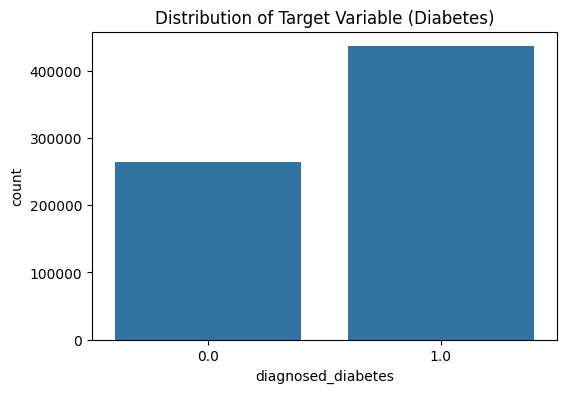

In [18]:
# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosed_diabetes', data=train_df)
plt.title('Distribution of Target Variable (Diabetes)')
plt.show()

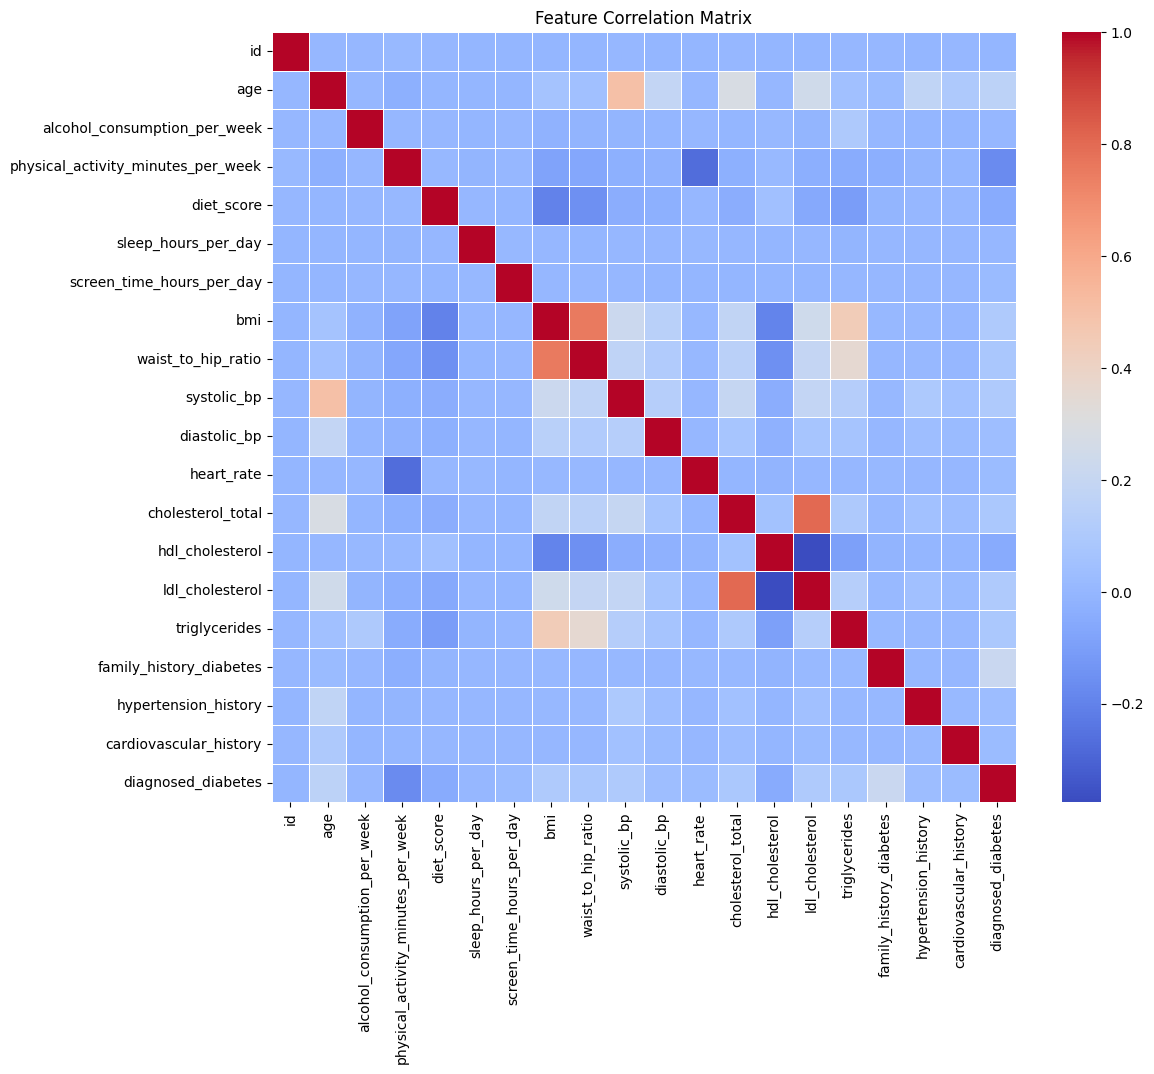

In [19]:
plt.figure(figsize=(12, 10))

# Select only numeric columns for correlation
numeric_df = train_df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

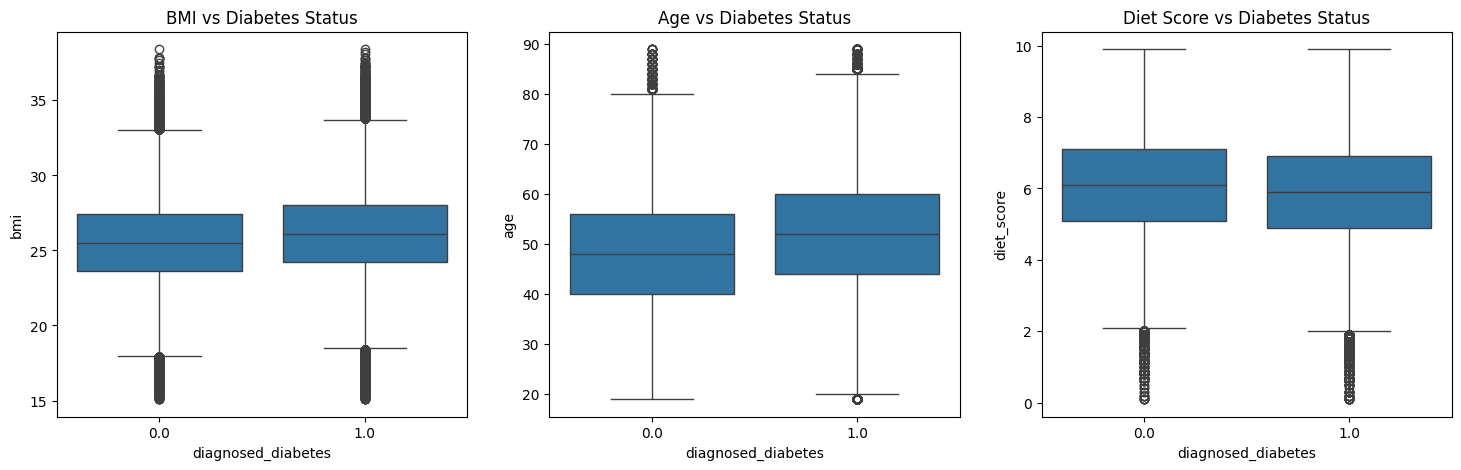

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='diagnosed_diabetes', y='bmi', data=train_df, ax=axes[0])
axes[0].set_title('BMI vs Diabetes Status')

sns.boxplot(x='diagnosed_diabetes', y='age', data=train_df, ax=axes[1])
axes[1].set_title('Age vs Diabetes Status')

sns.boxplot(x='diagnosed_diabetes', y='diet_score', data=train_df, ax=axes[2])
axes[2].set_title('Diet Score vs Diabetes Status')

plt.show()

In [21]:
# 1. Prepare Data
X = train_df.drop(['diagnosed_diabetes', 'id'], axis=1)
y = train_df['diagnosed_diabetes']

# 2. Preprocessing
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 3. Model Definition
# n_estimators=200 helps stabilize probability estimates
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# 4. Split for Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Train
clf.fit(X_train, y_train)
print("Model Trained.")

Model Trained.


In [22]:
# 1. Retrain on all available data for best performance
clf.fit(X, y)

# 2. Prepare Test Set
X_test = test_df.drop(['id'], axis=1)

# 3. Predict Probabilities
# We take the second column [:, 1] which corresponds to the probability of label '1'
test_probs = clf.predict_proba(X_test)[:, 1]

# 4. Create Submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'diagnosed_diabetes': test_probs
})

# 5. Save
submission.to_csv('submission.csv', index=False)

print("Submission file created.")
display(submission.head())

Submission file created.


,id,diagnosed_diabetes
0,700000,0.533399
1,700001,0.576104
2,700002,0.632504
3,700003,0.593126
4,700004,0.720206


Baseline Random Forest AUC: 0.6977
Improved XGBoost AUC:       0.7215


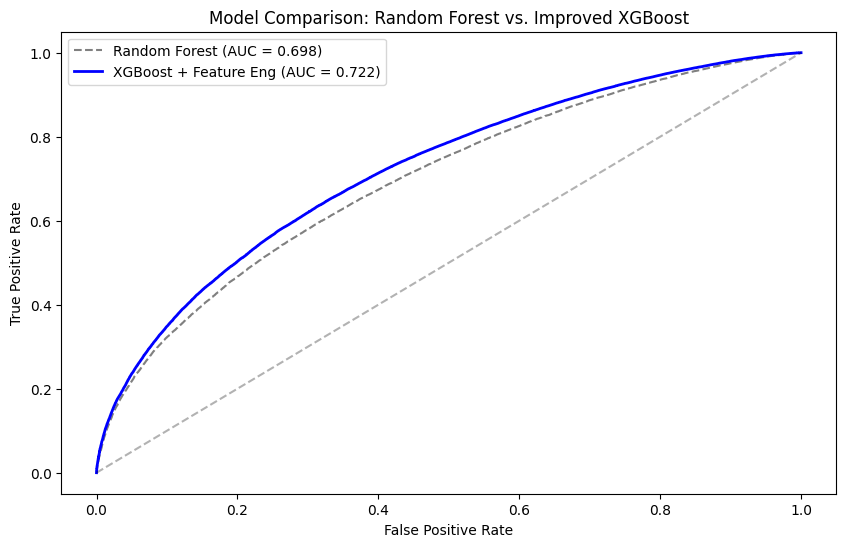

In [23]:
# !pip install xgboost

import xgboost as xgb

def new_features(df):
    df_eng = df.copy()
    df_eng['MAP'] = (df_eng['systolic_bp'] + 2 * df_eng['diastolic_bp']) / 3
    df_eng['Cholesterol_Ratio'] = df_eng['cholesterol_total'] / (df_eng['hdl_cholesterol'] + 1e-5)
    return df_eng

X_eng = new_features(X)
X_test_eng = new_features(X_test)

X_train_eng, X_val_eng, y_train_eng, y_val_eng = train_test_split(
    X_eng, y, test_size=0.3, random_state=42, stratify=y
)

clf.fit(X_train, y_train) 
y_pred_rf = clf.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, y_pred_rf)

# --- Model B: XGBoost (The "Challenger") ---
# XGBoost handles missing values natively, but we still encode categories
# We update the preprocessor to work with the new feature set
num_cols_eng = X_eng.select_dtypes(include=['int64', 'float64']).columns
cat_cols_eng = X_eng.select_dtypes(include=['object', 'bool']).columns

# Update preprocessor for new columns
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_eng),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_eng)
    ])

# Define XGBoost with parameters optimized for Tabular Data
model_xgb = xgb.XGBClassifier(
    n_estimators=500,        # More trees
    learning_rate=0.03,      # Slower learning rate prevents overfitting
    max_depth=6,             # Depth of trees
    subsample=0.8,           # Use 80% of data per tree (adds randomness)
    colsample_bytree=0.8,    # Use 80% of features per tree
    random_state=42,
    eval_metric='auc',
    n_jobs=-1                # Use all CPU cores
)

# Create Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb),
    ('classifier', model_xgb)
])

# Train the new model
xgb_pipeline.fit(X_train_eng, y_train_eng)

# Predict
y_pred_xgb = xgb_pipeline.predict_proba(X_val_eng)[:, 1]
auc_xgb = roc_auc_score(y_val_eng, y_pred_xgb)

# ==========================================
# 3. Compare Results
# ==========================================

print(f"Baseline Random Forest AUC: {auc_rf:.4f}")
print(f"Improved XGBoost AUC:       {auc_xgb:.4f}")

# Plot ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val_eng, y_pred_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linestyle='--', color='gray')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost + Feature Eng (AUC = {auc_xgb:.3f})', linewidth=2, color='blue')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison: Random Forest vs. Improved XGBoost')
plt.legend()
plt.show()
